In [309]:
import mysql.connector
import os
from dotenv import load_dotenv
import pandas as pd
load_dotenv()
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.tree import plot_tree
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from collections import Counter
from datetime import datetime, timedelta

In [97]:
conn = mysql.connector.connect(
    host=os.getenv("DB_HOST"),
    user=os.getenv("DB_USER"),
    password=os.getenv("DB_PASSWORD"),
    database='dublindb'
)
cursor = conn.cursor()

# Contacts

In [98]:
query = '''
    SELECT ts_contact_at, ts_reply_at, ts_accepted_at, ts_booking_at, time_to_reply, ds_checkin, ds_checkout, n_guests, n_messages
    FROM contacts;
'''
cursor.execute(query)
res = cursor.fetchall()

In [99]:
cols = ['ts_contact_at', 'ts_reply_at', 'ts_accepted_at', 'ts_booking_at', 'time_to_reply', 'ds_checkin', 'ds_checkout', 'n_guests', 'n_messages']
df = pd.DataFrame(res, columns=cols)
df.head()

ts_contact_at            ts_reply_at         ts_accepted_at  \
0  2014-10-04 16:26:28.0  2014-10-04 16:26:28.0  2014-10-04 16:26:28.0   
1  2014-11-04 09:10:03.0  2014-11-04 09:45:50.0  2014-11-04 09:45:50.0   
2  2014-10-10 12:02:50.0  2014-10-10 15:07:01.0                   None   
3  2014-10-10 15:23:53.0                   None                   None   
4  2014-10-10 15:22:26.0  2014-10-10 15:24:26.0  2014-10-10 15:24:26.0   

           ts_booking_at  time_to_reply  ds_checkin ds_checkout  n_guests  \
0  2014-10-04 16:26:28.0              0  2014-10-13  2014-10-15         2   
1  2014-11-04 12:20:46.0           2147  2014-11-27  2014-11-30         1   
2                   None          11051  2014-10-17  2014-10-19         2   
3                   None              0  2014-10-17  2014-10-19         2   
4  2014-10-10 15:52:42.0            120  2014-10-17  2014-10-19         2   

   n_messages  
0          13  
1          10  
2           3  
3           2  
4          14

In [100]:
le = LabelEncoder()
df['ts_contact_at'] = le.fit_transform(df['ts_contact_at'])
df['ts_reply_at'] = le.fit_transform(df['ts_reply_at'])
df['ts_accepted_at'] = le.fit_transform(df['ts_accepted_at'])
df['ds_checkin'] = le.fit_transform(df['ds_checkin'])
df['ds_checkout'] = le.fit_transform(df['ds_checkout'])
df.head()

ts_contact_at  ts_reply_at  ts_accepted_at          ts_booking_at  \
0           2363         2013             929  2014-10-04 16:26:28.0   
1           7362         6797            3413  2014-11-04 12:20:46.0   
2           4581         4154            3627                   None   
3           4646         7207            3627                   None   
4           4644         4158            2007  2014-10-10 15:52:42.0   

   time_to_reply  ds_checkin  ds_checkout  n_guests  n_messages  
0              0          12           13         2          13  
1           2147          57           59         1          10  
2          11051          16           17         2           3  
3              0          16           17         2           2  
4            120          16           17         2          14

In [101]:
df['booked'] = df['ts_booking_at'].apply(lambda x: 1 if x is not None else 0)
df.drop('ts_booking_at', axis=1, inplace=True)
df.head()

ts_contact_at  ts_reply_at  ts_accepted_at  time_to_reply  ds_checkin  \
0           2363         2013             929              0          12   
1           7362         6797            3413           2147          57   
2           4581         4154            3627          11051          16   
3           4646         7207            3627              0          16   
4           4644         4158            2007            120          16   

   ds_checkout  n_guests  n_messages  booked  
0           13         2          13       1  
1           59         1          10       1  
2           17         2           3       0  
3           17         2           2       0  
4           17         2          14       1

In [102]:
# correlation matrix
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

In [103]:
X = df.drop('booked', axis=1)
y = df['booked']

In [104]:
X.head()

ts_contact_at  ts_reply_at  ts_accepted_at  time_to_reply  ds_checkin  \
0           2363         2013             929              0          12   
1           7362         6797            3413           2147          57   
2           4581         4154            3627          11051          16   
3           4646         7207            3627              0          16   
4           4644         4158            2007            120          16   

   ds_checkout  n_guests  n_messages  
0           13         2          13  
1           59         1          10  
2           17         2           3  
3           17         2           2  
4           17         2          14

In [105]:
y

0       1
1       1
2       0
3       0
4       1
       ..
7818    0
7819    0
7820    0
7821    0
7822    0
Name: booked, Length: 7823, dtype: int64

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

## Random Forest Classifier

In [107]:
classifier_rf = RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=5,
                                       n_estimators=100, oob_score=True)

In [108]:
classifier_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, n_jobs=-1, oob_score=True, random_state=42)

In [109]:
classifier_rf.oob_score_

0.9150840029218408

In [110]:
classifier_rf.score(X_train, y_train)

0.9191015339663988

In [111]:
classifier_rf.score(X_test, y_test)

0.9233063485300383

Param Sweep

In [112]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

In [113]:
params = {
    'max_depth': [2,3,5,10,20],
    'min_samples_leaf': [5,10,20,50,100,200],
    'n_estimators': [10,25,30,50,100,200]
}

In [114]:
grid_search = GridSearchCV(estimator=rf,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, verbose=1, scoring="accuracy")

In [115]:
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 180 candidates, totalling 720 fits


GridSearchCV(cv=4, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100, 200],
                         'n_estimators': [10, 25, 30, 50, 100, 200]},
             scoring='accuracy', verbose=1)

In [116]:
grid_search.best_score_

0.9176406135865596

In [117]:
rf_best = grid_search.best_estimator_
rf_best

RandomForestClassifier(max_depth=20, min_samples_leaf=5, n_jobs=-1,
                       random_state=42)

In [118]:
rf_best.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 20,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

Plot

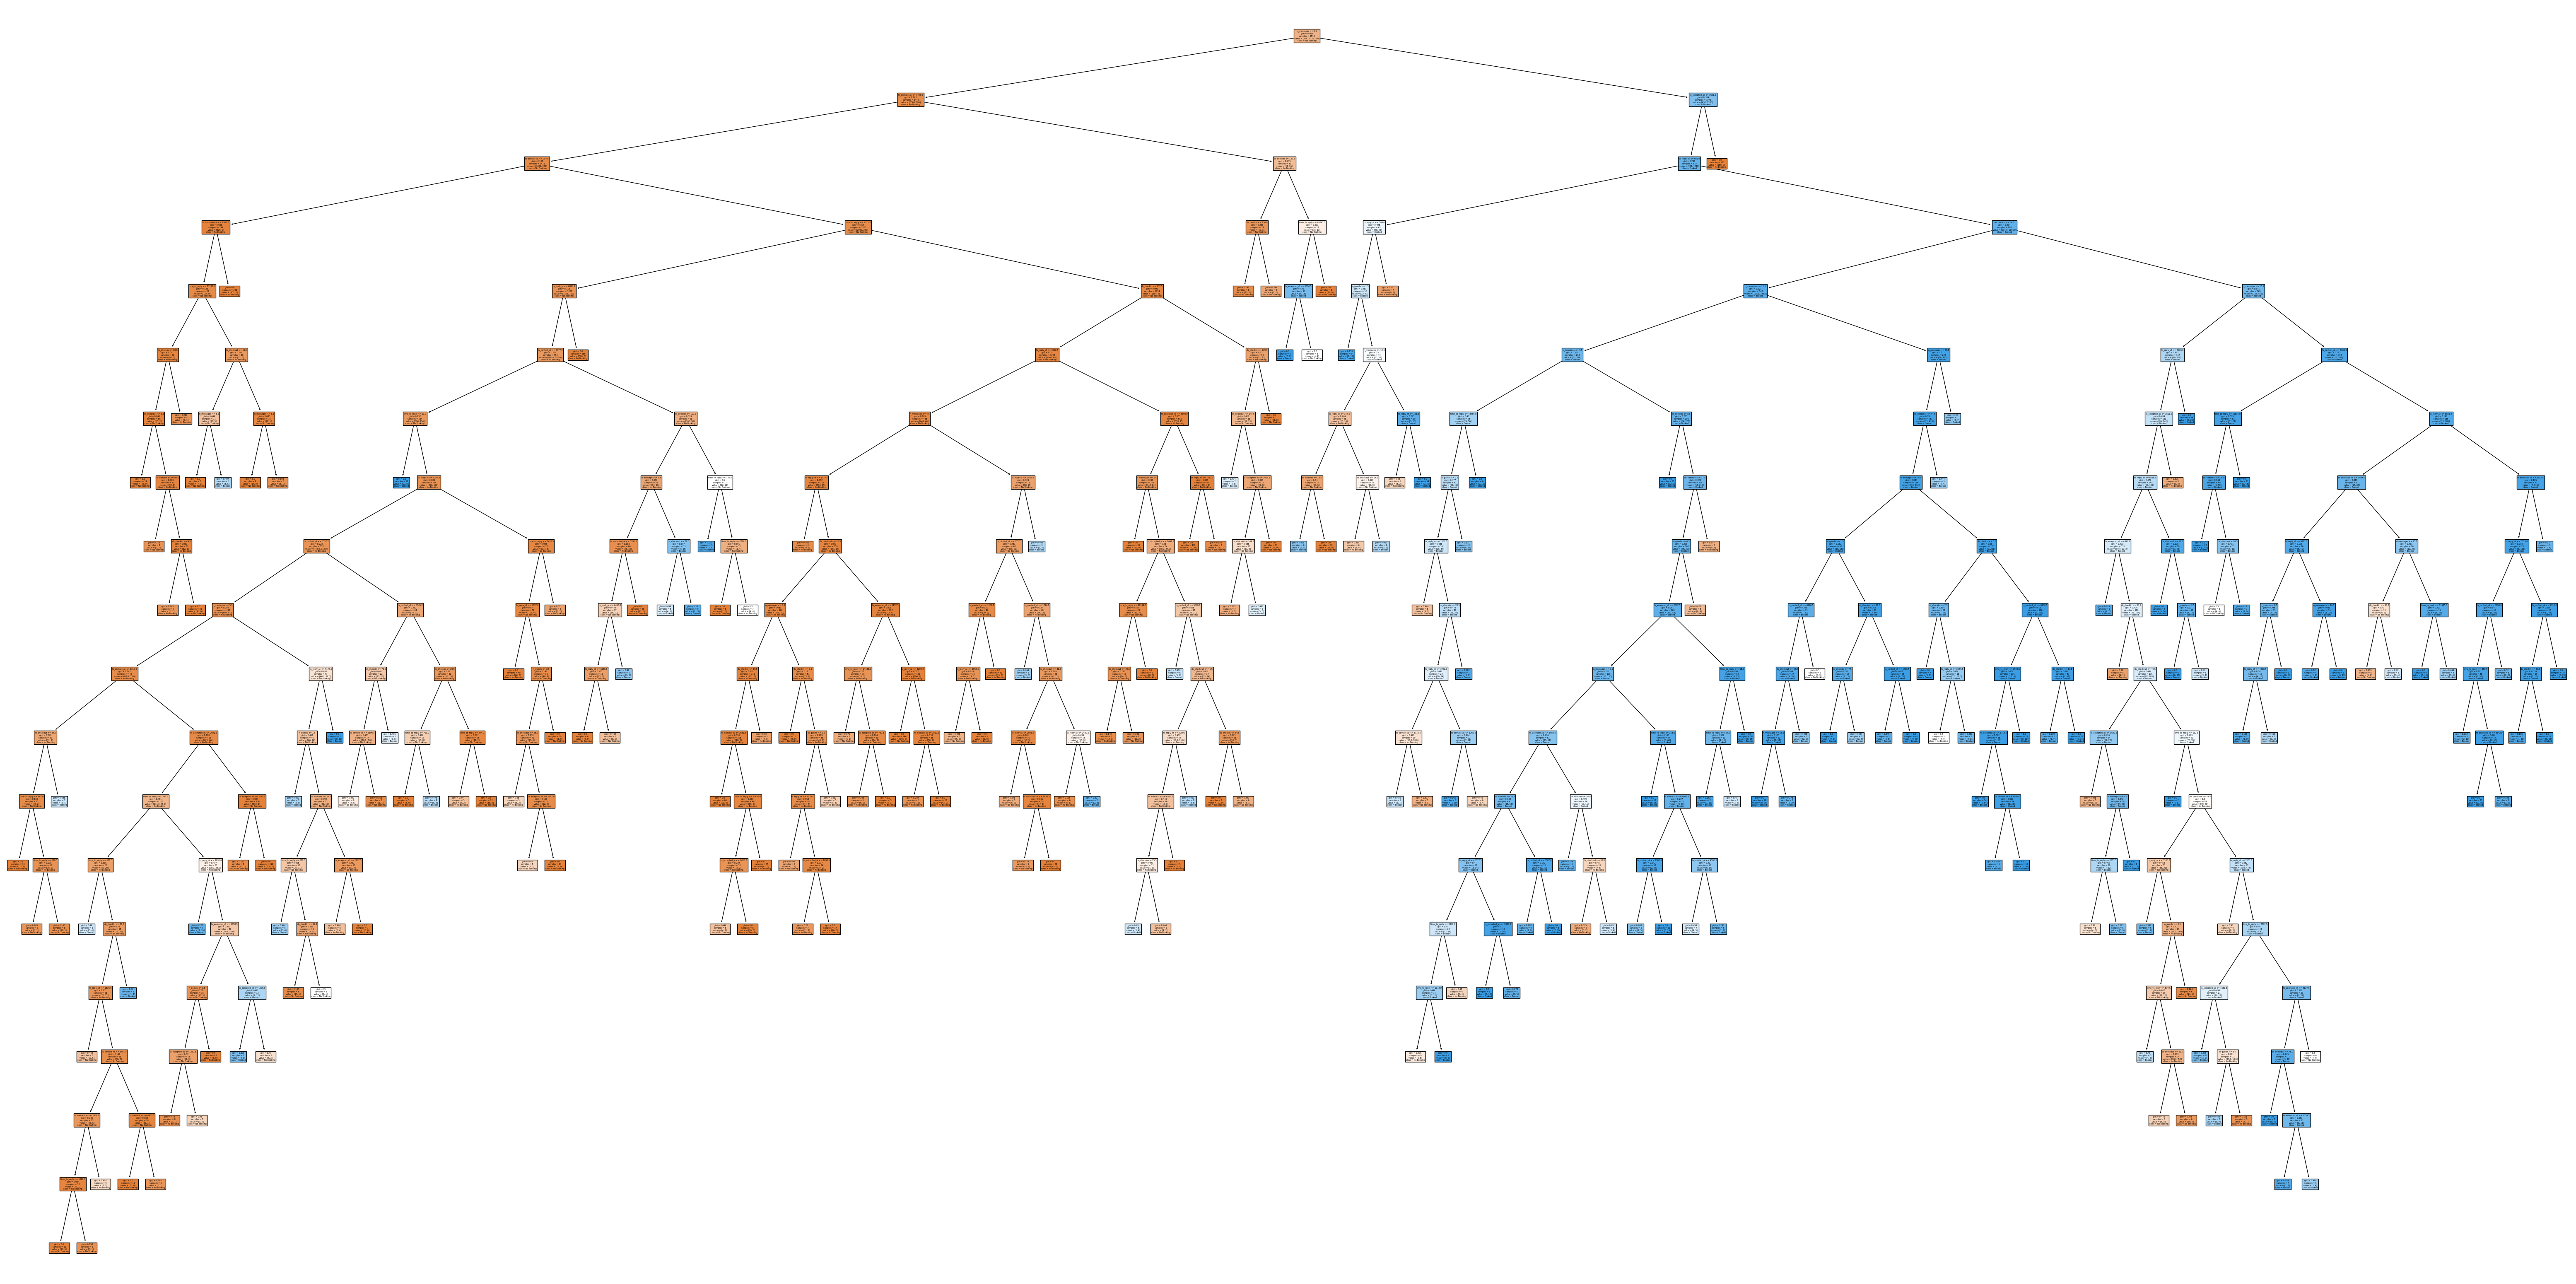

In [119]:
plt.figure(figsize=(80,40))
plot_tree(rf_best.estimators_[5], feature_names = X.columns,class_names=['No Booking', "Booked"],filled=True);

Identify most important features

In [120]:
selector = SelectKBest(score_func=f_classif, k=5)
selector.fit(X_train, y_train)
selected_indices = selector.get_support(indices=True)
selected_features = X_train.columns[selected_indices]
print(selected_features)

Index(['ts_contact_at', 'ts_accepted_at', 'time_to_reply', 'ds_checkout',
       'n_messages'],
      dtype='object')


Use best params from sweep

In [121]:
classifier_rf = RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=20,
                                       n_estimators=100, min_samples_leaf=5, oob_score=True)

In [122]:
classifier_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, min_samples_leaf=5, n_jobs=-1,
                       oob_score=True, random_state=42)

In [123]:
classifier_rf.oob_score_

0.9178232286340394

In [124]:
classifier_rf.score(X_test, y_test)

0.9284192586280358

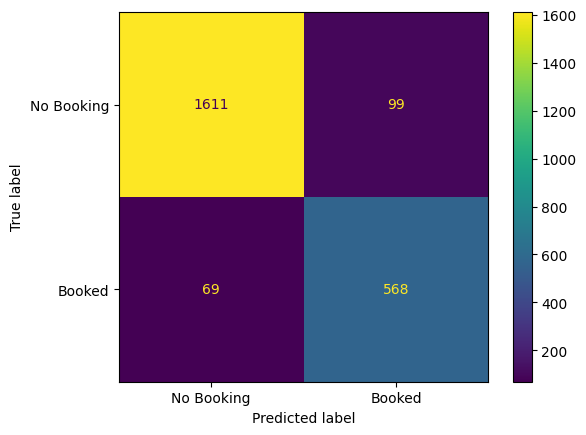

In [125]:
cm = confusion_matrix(y_test, classifier_rf.predict(X_test))
ConfusionMatrixDisplay(cm, display_labels=['No Booking', 'Booked']).plot()

# Combined

Contacts & Searches

In [126]:
query = '''
    SELECT
        c.ts_contact_at,
        c.ts_reply_at,
        c.ts_accepted_at,
        c.ts_booking_at,
        c.time_to_reply,
        c.ds_checkin,
        c.ds_checkout,
        c.n_guests,
        c.n_messages,
        AVG(s.n_searches) AS n_searches,
        AVG(s.n_nights) AS search_n_nights,
        AVG(s.n_guests_min) AS search_n_guests_min,
        AVG(s.n_guests_max) AS search_n_guests_max,
        AVG(s.filter_price_min) AS search_filter_price_min,
        AVG(s.filter_price_max) AS search_filter_price_max,
        s.origin_country AS origin_country,
        GROUP_CONCAT(IFNULL(s.filter_room_types, '') SEPARATOR ',') AS filter_room_types,
        GROUP_CONCAT(IFNULL(s.filter_neighborhoods, '') SEPARATOR ',') AS filter_neighborhoods
    FROM
        contacts c
    LEFT JOIN
        searches s ON c.id_guest = s.id_user
    WHERE
        s.ds < c.ts_contact_at
    GROUP BY
        c.id_guest,
        c.id_host,
        c.ts_contact_at,
        c.ts_reply_at,
        c.ts_accepted_at,
        c.ts_booking_at,
        c.time_to_reply,
        c.ds_checkin,
        c.ds_checkout,
        c.n_guests,
        c.n_messages,
        s.origin_country
'''
cursor.execute(query)
res = cursor.fetchall()

In [127]:
cols = ['ts_contact_at', 'ts_reply_at', 'ts_accepted_at', 
        'ts_booking_at', 'time_to_reply', 
        'ds_checkin', 'ds_checkout', 'n_guests', 'n_messages', 'n_searches', 
        'search_n_nights', 'search_n_guests_min', 'search_n_guests_max', 
        'search_filter_price_min', 'search_filter_price_max', 'origin_country', 
        'filter_room_types', 'filter_neighborhoods']
df = pd.DataFrame(res, columns=cols)
df.head()

ts_contact_at            ts_reply_at         ts_accepted_at  \
0  2014-10-04 16:26:28.0  2014-10-04 16:26:28.0  2014-10-04 16:26:28.0   
1  2014-11-04 09:10:03.0  2014-11-04 09:45:50.0  2014-11-04 09:45:50.0   
2  2014-10-10 12:02:50.0  2014-10-10 15:07:01.0                   None   
3  2014-10-10 15:23:53.0                   None                   None   
4  2014-10-10 15:22:26.0  2014-10-10 15:24:26.0  2014-10-10 15:24:26.0   

           ts_booking_at  time_to_reply  ds_checkin ds_checkout  n_guests  \
0  2014-10-04 16:26:28.0              0  2014-10-13  2014-10-15         2   
1  2014-11-04 12:20:46.0           2147  2014-11-27  2014-11-30         1   
2                   None          11051  2014-10-17  2014-10-19         2   
3                   None              0  2014-10-17  2014-10-19         2   
4  2014-10-10 15:52:42.0            120  2014-10-17  2014-10-19         2   

   n_messages n_searches  search_n_nights search_n_guests_min  \
0          13     6.0000              2.0              2.0000   
1          10    13.0000              3.0              1.0000   
2           3    32.5000              2.0              2.0000   
3           2    32.5000              2.0              2.0000   
4          14    32.5000              2.0              2.0000   

  search_n_guests_max  search_filter_price_min  search_filter_price_max  \
0              2.0000                      0.0                    130.0   
1              1.0000                      0.0                    336.0   
2              2.0000                      0.0                    736.0   
3              2.0000                      0.0                    736.0   
4              2.0000                      0.0                    736.0   

  origin_country                                  filter_room_types  \
0             CA                                   ,Entire home/apt   
1             DK         ,Entire home/apt,Private room,Private room   
2             CY  ,Entire home/apt,,Entire home/apt,Entire home/...   
3             CY  ,Entire home/apt,Entire home/apt,Private room,...   
4             CY  ,Entire home/apt,,Entire home/apt,Entire home/...   

  filter_neighborhoods  
0                       
1                       
2                    ,  
3                    ,  
4                    ,

In [128]:
filter_room_types_lists = df['filter_room_types'].str.split(',').tolist()

In [129]:
flattened_list = [room_type for sublist in filter_room_types_lists for room_type in sublist]

In [130]:
unique_room_types = set(flattened_list) - {''}
unique_room_types

{'Entire home/apt', 'Privat', 'Private room', 'Shared room'}

In [131]:
df['filter_room_types'].str.get_dummies(sep=',')

Entire home/apt  Privat  Private room  Shared room
0                   1       0             0            0
1                   1       0             1            0
2                   1       0             1            0
3                   1       0             1            0
4                   1       0             1            0
...               ...     ...           ...          ...
6941                0       0             0            0
6942                0       0             0            0
6943                0       0             0            0
6944                0       0             0            0
6945                0       0             0            0

[6946 rows x 4 columns]

In [132]:
room_type_counts_df = (pd.DataFrame([Counter(x.split(',')) for x in df['filter_room_types']])
         .fillna(0)
         .astype(int)).drop('', axis=1)
room_type_counts_df.head()

Entire home/apt  Private room  Shared room  Privat
0                1             0            0       0
1                1             2            0       0
2                3             2            0       0
3                3             2            0       0
4                3             2            0       0

In [133]:
df = pd.concat([df.drop('filter_room_types', axis=1), room_type_counts_df], axis=1)
df.head()

ts_contact_at            ts_reply_at         ts_accepted_at  \
0  2014-10-04 16:26:28.0  2014-10-04 16:26:28.0  2014-10-04 16:26:28.0   
1  2014-11-04 09:10:03.0  2014-11-04 09:45:50.0  2014-11-04 09:45:50.0   
2  2014-10-10 12:02:50.0  2014-10-10 15:07:01.0                   None   
3  2014-10-10 15:23:53.0                   None                   None   
4  2014-10-10 15:22:26.0  2014-10-10 15:24:26.0  2014-10-10 15:24:26.0   

           ts_booking_at  time_to_reply  ds_checkin ds_checkout  n_guests  \
0  2014-10-04 16:26:28.0              0  2014-10-13  2014-10-15         2   
1  2014-11-04 12:20:46.0           2147  2014-11-27  2014-11-30         1   
2                   None          11051  2014-10-17  2014-10-19         2   
3                   None              0  2014-10-17  2014-10-19         2   
4  2014-10-10 15:52:42.0            120  2014-10-17  2014-10-19         2   

   n_messages n_searches  ...  search_n_guests_min search_n_guests_max  \
0          13     6.0000  ...               2.0000              2.0000   
1          10    13.0000  ...               1.0000              1.0000   
2           3    32.5000  ...               2.0000              2.0000   
3           2    32.5000  ...               2.0000              2.0000   
4          14    32.5000  ...               2.0000              2.0000   

  search_filter_price_min  search_filter_price_max  origin_country  \
0                     0.0                    130.0              CA   
1                     0.0                    336.0              DK   
2                     0.0                    736.0              CY   
3                     0.0                    736.0              CY   
4                     0.0                    736.0              CY   

  filter_neighborhoods Entire home/apt  Private room  Shared room  Privat  
0                                    1             0            0       0  
1                                    1             2            0       0  
2                    ,               3             2            0       0  
3                    ,               3             2            0       0  
4                    ,               3             2            0       0  

[5 rows x 21 columns]

In [134]:
filter_neighborhood_lists = df['filter_neighborhoods'].str.split(',').tolist()
flattened_neighborhood_list = [neighborhood for sublist in filter_neighborhood_lists for neighborhood in sublist]
unique_neighborhoods = set(flattened_neighborhood_list) - {''}
unique_neighborhoods

{'Addison Park',
 'Ardilea',
 'Artane',
 'Ballinteer',
 'Ballsbridge',
 'Ballybough',
 'Ballyfermot',
 'Ballymun',
 'Beaumont',
 'Blackrock',
 'Bonnybrook/Darndale',
 'Booterstown',
 'Cabra',
 'City Centre',
 'Clondalkin',
 'Clontarf',
 'Courtlands',
 'Dartry',
 'Docklands',
 'Donnybrook',
 'Drumcondra',
 'Dundrum',
 'East Wall',
 'Edenmore',
 'Fairview',
 'Finglas',
 'Georgian Quarter',
 'Glasnevin',
 'Gra',
 'Graft',
 'Grafton Street/St. Stephens Green',
 'Inchicore',
 'Islandbridge',
 'Kilmainham',
 'Kimmage',
 'Knocklyon',
 'Marino',
 'Monkstown',
 "North City Central/O'Connell Street",
 'North Strand',
 'Old City',
 'Phibsborough',
 'Phoenix Park and Surrounds',
 'Portobello',
 'Raheny',
 'Ranela',
 'Ranelagh ',
 'Ranelagh and Rathmines',
 'Rathfarnham',
 'Rathgar',
 'Rialto',
 'Ringsend/Irishtown',
 'Sandymount',
 'Santry',
 'Smithfield',
 'Stoneybatter/Arbour Hill',
 'Temple Bar',
 'Trinity College'}

In [135]:
neighborhood_counts_df = (pd.DataFrame([Counter(x.split(',')) for x in df['filter_neighborhoods']])
         .fillna(0)
         .astype(int)).drop('', axis=1)
neighborhood_counts_df.head()

City Centre  Ballsbridge  Grafton Street/St. Stephens Green  Temple Bar  \
0            0            0                                  0           0   
1            0            0                                  0           0   
2            0            0                                  0           0   
3            0            0                                  0           0   
4            0            0                                  0           0   

   Trinity College  Marino  Drumcondra  Old City  Docklands  Ardilea  ...  \
0                0       0           0         0          0        0  ...   
1                0       0           0         0          0        0  ...   
2                0       0           0         0          0        0  ...   
3                0       0           0         0          0        0  ...   
4                0       0           0         0          0        0  ...   

   Knocklyon  Santry  Ranelagh   Graft  Ranela  Gra  Rathfarnham  Dundrum  \
0          0       0          0      0       0    0            0        0   
1          0       0          0      0       0    0            0        0   
2          0       0          0      0       0    0            0        0   
3          0       0          0      0       0    0            0        0   
4          0       0          0      0       0    0            0        0   

   Clondalkin  Booterstown  
0           0            0  
1           0            0  
2           0            0  
3           0            0  
4           0            0  

[5 rows x 58 columns]

In [136]:
df = pd.concat([df.drop('filter_neighborhoods', axis=1), neighborhood_counts_df], axis=1)
df.head()

ts_contact_at            ts_reply_at         ts_accepted_at  \
0  2014-10-04 16:26:28.0  2014-10-04 16:26:28.0  2014-10-04 16:26:28.0   
1  2014-11-04 09:10:03.0  2014-11-04 09:45:50.0  2014-11-04 09:45:50.0   
2  2014-10-10 12:02:50.0  2014-10-10 15:07:01.0                   None   
3  2014-10-10 15:23:53.0                   None                   None   
4  2014-10-10 15:22:26.0  2014-10-10 15:24:26.0  2014-10-10 15:24:26.0   

           ts_booking_at  time_to_reply  ds_checkin ds_checkout  n_guests  \
0  2014-10-04 16:26:28.0              0  2014-10-13  2014-10-15         2   
1  2014-11-04 12:20:46.0           2147  2014-11-27  2014-11-30         1   
2                   None          11051  2014-10-17  2014-10-19         2   
3                   None              0  2014-10-17  2014-10-19         2   
4  2014-10-10 15:52:42.0            120  2014-10-17  2014-10-19         2   

   n_messages n_searches  ...  Knocklyon Santry Ranelagh   Graft  Ranela Gra  \
0          13     6.0000  ...          0      0         0      0       0   0   
1          10    13.0000  ...          0      0         0      0       0   0   
2           3    32.5000  ...          0      0         0      0       0   0   
3           2    32.5000  ...          0      0         0      0       0   0   
4          14    32.5000  ...          0      0         0      0       0   0   

   Rathfarnham  Dundrum  Clondalkin  Booterstown  
0            0        0           0            0  
1            0        0           0            0  
2            0        0           0            0  
3            0        0           0            0  
4            0        0           0            0  

[5 rows x 78 columns]

In [137]:
le = LabelEncoder()
df['ts_contact_at'] = le.fit_transform(df['ts_contact_at'])
df['ts_reply_at'] = le.fit_transform(df['ts_reply_at'])
df['ts_accepted_at'] = le.fit_transform(df['ts_accepted_at'])
df['ds_checkin'] = le.fit_transform(df['ds_checkin'])
df['ds_checkout'] = le.fit_transform(df['ds_checkout'])
df['origin_country'] = le.fit_transform(df['origin_country'])
df.head()

ts_contact_at  ts_reply_at  ts_accepted_at          ts_booking_at  \
0           1497         1239             604  2014-10-04 16:26:28.0   
1           6486         6000            3081  2014-11-04 12:20:46.0   
2           3708         3367            3295                   None   
3           3773         6410            3295                   None   
4           3771         3371            1676  2014-10-10 15:52:42.0   

   time_to_reply  ds_checkin  ds_checkout  n_guests  n_messages n_searches  \
0              0          12           13         2          13     6.0000   
1           2147          57           59         1          10    13.0000   
2          11051          16           17         2           3    32.5000   
3              0          16           17         2           2    32.5000   
4            120          16           17         2          14    32.5000   

   ...  Knocklyon Santry Ranelagh   Graft  Ranela  Gra  Rathfarnham  Dundrum  \
0  ...          0      0         0      0       0    0            0        0   
1  ...          0      0         0      0       0    0            0        0   
2  ...          0      0         0      0       0    0            0        0   
3  ...          0      0         0      0       0    0            0        0   
4  ...          0      0         0      0       0    0            0        0   

   Clondalkin  Booterstown  
0           0            0  
1           0            0  
2           0            0  
3           0            0  
4           0            0  

[5 rows x 78 columns]

In [138]:
df['booked'] = df['ts_booking_at'].apply(lambda x: 1 if x is not None else 0)
df.drop('ts_booking_at', axis=1, inplace=True)
df.head()

ts_contact_at  ts_reply_at  ts_accepted_at  time_to_reply  ds_checkin  \
0           1497         1239             604              0          12   
1           6486         6000            3081           2147          57   
2           3708         3367            3295          11051          16   
3           3773         6410            3295              0          16   
4           3771         3371            1676            120          16   

   ds_checkout  n_guests  n_messages n_searches  search_n_nights  ... Santry  \
0           13         2          13     6.0000              2.0  ...      0   
1           59         1          10    13.0000              3.0  ...      0   
2           17         2           3    32.5000              2.0  ...      0   
3           17         2           2    32.5000              2.0  ...      0   
4           17         2          14    32.5000              2.0  ...      0   

  Ranelagh   Graft  Ranela  Gra  Rathfarnham  Dundrum  Clondalkin  \
0         0      0       0    0            0        0           0   
1         0      0       0    0            0        0           0   
2         0      0       0    0            0        0           0   
3         0      0       0    0            0        0           0   
4         0      0       0    0            0        0           0   

   Booterstown  booked  
0            0       1  
1            0       1  
2            0       0  
3            0       0  
4            0       1  

[5 rows x 78 columns]

In [139]:
X = df.drop('booked', axis=1)
y = df['booked']

In [140]:
# correlation matrix
corr = X.corr()
corr.style.background_gradient(cmap='coolwarm')

In [141]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

## Random Forest Classifier

In [142]:
classifier_rf_both = RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=20,
                                       n_estimators=100, min_samples_leaf=5, oob_score=True)

In [143]:
classifier_rf_both.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, min_samples_leaf=5, n_jobs=-1,
                       oob_score=True, random_state=42)

In [144]:
classifier_rf_both.oob_score_

0.9193747429041547

In [145]:
classifier_rf_both.score(X_train, y_train)

0.9407651172357054

In [146]:
classifier_rf_both.score(X_test, y_test)

0.9112284069097889

In [147]:
rf_both = RandomForestClassifier(random_state=42, n_jobs=-1)

In [148]:
params = {
    'max_depth': [2,3,5,10,20],
    'min_samples_leaf': [5,10,20,50,100,200],
    'n_estimators': [10,25,30,50,100,200]
}

In [149]:
grid_search = GridSearchCV(estimator=rf_both,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, verbose=1, scoring="accuracy")

In [150]:
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 180 candidates, totalling 720 fits


GridSearchCV(cv=4, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100, 200],
                         'n_estimators': [10, 25, 30, 50, 100, 200]},
             scoring='accuracy', verbose=1)

In [151]:
grid_search.best_score_

0.9181393153021442

In [152]:
rf_best = grid_search.best_estimator_
rf_best

RandomForestClassifier(max_depth=20, min_samples_leaf=5, n_estimators=30,
                       n_jobs=-1, random_state=42)

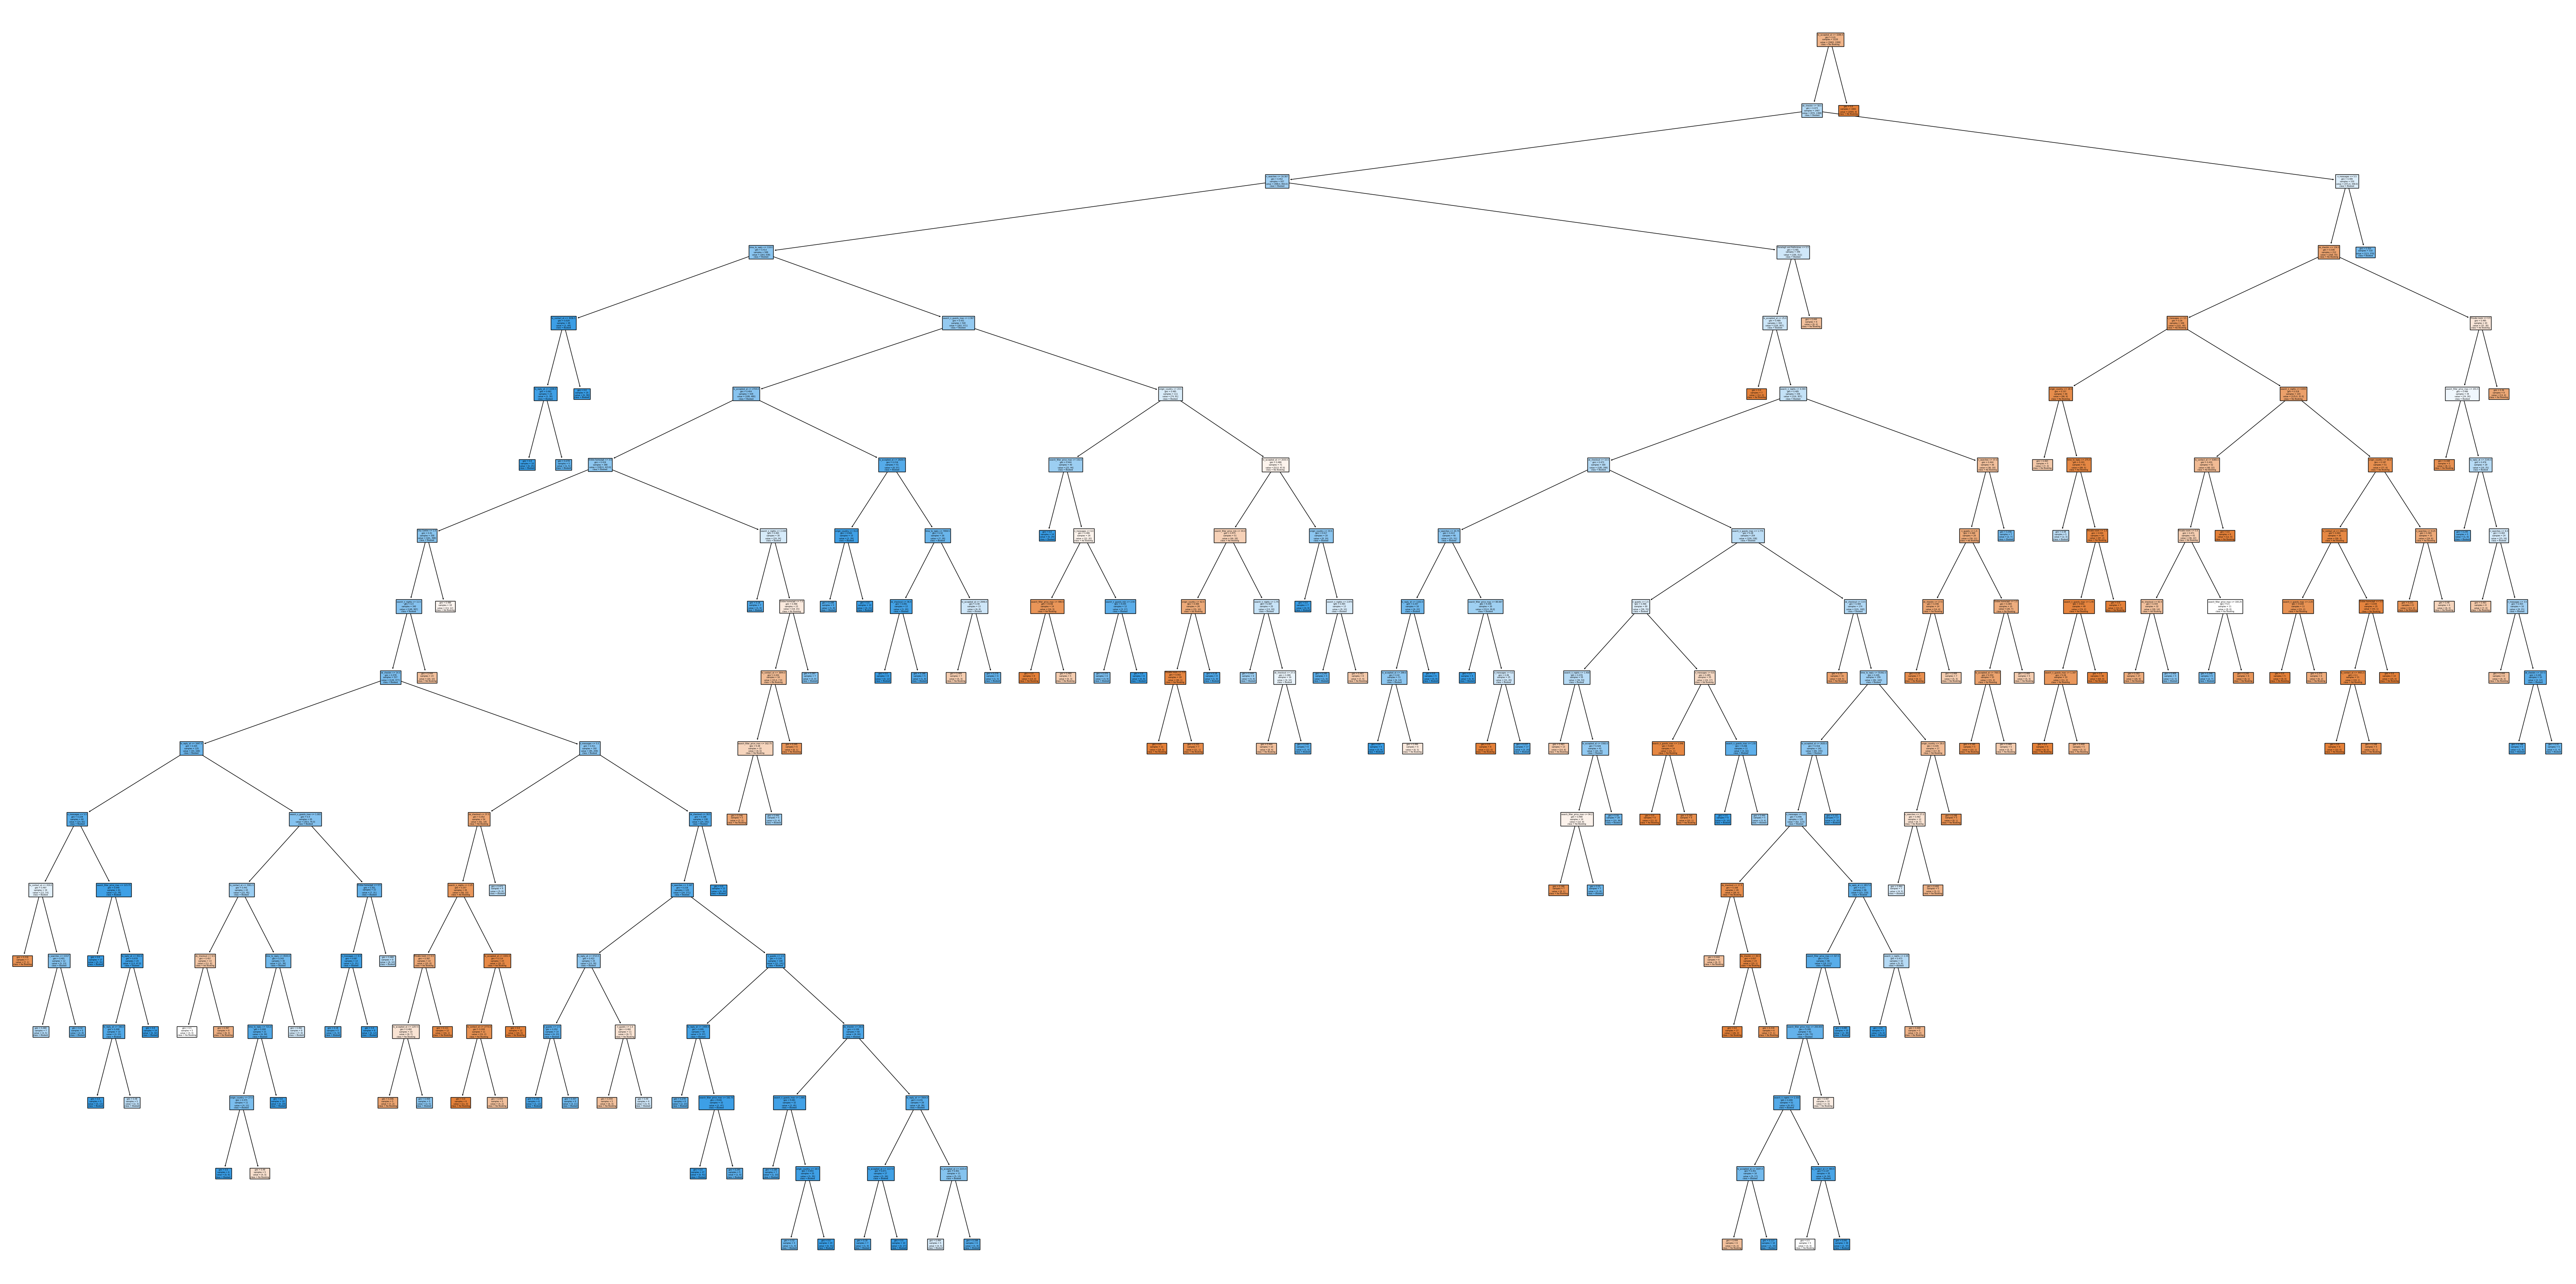

In [153]:
plt.figure(figsize=(80,40))
plot_tree(rf_best.estimators_[5], feature_names = X.columns,class_names=['No Booking', "Booked"],filled=True);

In [154]:
imp_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": rf_best.feature_importances_
})

imp_df.sort_values(by="Importance", ascending=False).head(20)

Feature  Importance
7                n_messages    0.481232
2            ts_accepted_at    0.283909
1               ts_reply_at    0.034195
3             time_to_reply    0.031377
9           search_n_nights    0.026152
8                n_searches    0.019987
0             ts_contact_at    0.017261
5               ds_checkout    0.016791
14           origin_country    0.014260
4                ds_checkin    0.013788
13  search_filter_price_max    0.013622
11      search_n_guests_max    0.009763
10      search_n_guests_min    0.009191
15          Entire home/apt    0.007609
6                  n_guests    0.006762
16             Private room    0.004415
12  search_filter_price_min    0.003194
17              Shared room    0.002406
19              City Centre    0.001469
46                  Finglas    0.000326

In [155]:
imp_df.sort_values(by="Importance", ascending=False).tail(20)

Feature  Importance
18                    Privat         0.0
54                Smithfield         0.0
31              Addison Park         0.0
25                Drumcondra         0.0
33                Ballinteer         0.0
34                Ballybough         0.0
35               Ballyfermot         0.0
37                  Beaumont         0.0
24                    Marino         0.0
39                  Clontarf         0.0
40                 East Wall         0.0
43                Courtlands         0.0
45                  Edenmore         0.0
47  Stoneybatter/Arbour Hill         0.0
48       Bonnybrook/Darndale         0.0
49                Kilmainham         0.0
50                   Kimmage         0.0
51                 Monkstown         0.0
52                   Rathgar         0.0
76               Booterstown         0.0

In [164]:
important_features = imp_df.loc[imp_df['Importance'] != 0, 'Feature']

In [167]:
X_filtered = X[important_features]
X_filtered.head()

ts_contact_at  ts_reply_at  ts_accepted_at  time_to_reply  ds_checkin  \
0           1497         1239             604              0          12   
1           6486         6000            3081           2147          57   
2           3708         3367            3295          11051          16   
3           3773         6410            3295              0          16   
4           3771         3371            1676            120          16   

   ds_checkout  n_guests  n_messages n_searches  search_n_nights  ...  \
0           13         2          13     6.0000              2.0  ...   
1           59         1          10    13.0000              3.0  ...   
2           17         2           3    32.5000              2.0  ...   
3           17         2           2    32.5000              2.0  ...   
4           17         2          14    32.5000              2.0  ...   

  Ballymun Blackrock  Fairview  North Strand  Donnybrook  Finglas  Portobello  \
0        0         0         0             0           0        0           0   
1        0         0         0             0           0        0           0   
2        0         0         0             0           0        0           0   
3        0         0         0             0           0        0           0   
4        0         0         0             0           0        0           0   

   Sandymount  Phibsborough  Dundrum  
0           0             0        0  
1           0             0        0  
2           0             0        0  
3           0             0        0  
4           0             0        0  

[5 rows x 38 columns]

In [227]:
X_train_filtered, X_test_filtered, y_train_filtered, y_test_filtered = train_test_split(X_filtered, y, train_size=0.7, random_state=42)

In [228]:
classifier_rf_filtered = RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=20,
                                       n_estimators=200, min_samples_leaf=5, oob_score=True)

In [229]:
classifier_rf_filtered.fit(X_train_filtered, y_train_filtered)

RandomForestClassifier(max_depth=20, min_samples_leaf=5, n_estimators=200,
                       n_jobs=-1, oob_score=True, random_state=42)

In [230]:
classifier_rf_filtered.oob_score_

0.9236939531057178

In [231]:
classifier_rf_filtered.score(X_train_filtered, y_train_filtered)

0.9594816947758125

In [232]:
classifier_rf_filtered.score(X_test_filtered, y_test_filtered)

0.9227447216890595

In [233]:
imp_df_filtered = pd.DataFrame({
    "Feature": X_train_filtered.columns,
    "Importance": classifier_rf_filtered.feature_importances_
})

imp_df_filtered.sort_values(by="Importance", ascending=False)

Feature  Importance
7                            n_messages    0.432122
2                        ts_accepted_at    0.312685
3                         time_to_reply    0.045202
9                       search_n_nights    0.032402
1                           ts_reply_at    0.029310
8                            n_searches    0.019454
5                           ds_checkout    0.018798
4                            ds_checkin    0.017328
0                         ts_contact_at    0.017077
13              search_filter_price_max    0.015662
14                       origin_country    0.012892
11                  search_n_guests_max    0.010666
10                  search_n_guests_min    0.010307
15                      Entire home/apt    0.006809
6                              n_guests    0.006606
16                         Private room    0.005050
18                          City Centre    0.002511
12              search_filter_price_min    0.002473
17                          Shared room    0.001098
21                           Temple Bar    0.000241
22                      Trinity College    0.000207
30                             Fairview    0.000170
24                            Docklands    0.000152
25               Ranelagh and Rathmines    0.000138
26  North City Central/O'Connell Street    0.000131
23                             Old City    0.000113
33                              Finglas    0.000085
31                         North Strand    0.000081
20    Grafton Street/St. Stephens Green    0.000064
34                           Portobello    0.000053
27                               Artane    0.000050
19                          Ballsbridge    0.000033
32                           Donnybrook    0.000025
36                         Phibsborough    0.000008
29                            Blackrock    0.000000
28                             Ballymun    0.000000
35                           Sandymount    0.000000
37                              Dundrum    0.000000

Filter top 20 important features

In [234]:
imp_df_filtered.sort_values(by="Importance", ascending=False)[:20]

Feature  Importance
7                n_messages    0.432122
2            ts_accepted_at    0.312685
3             time_to_reply    0.045202
9           search_n_nights    0.032402
1               ts_reply_at    0.029310
8                n_searches    0.019454
5               ds_checkout    0.018798
4                ds_checkin    0.017328
0             ts_contact_at    0.017077
13  search_filter_price_max    0.015662
14           origin_country    0.012892
11      search_n_guests_max    0.010666
10      search_n_guests_min    0.010307
15          Entire home/apt    0.006809
6                  n_guests    0.006606
16             Private room    0.005050
18              City Centre    0.002511
12  search_filter_price_min    0.002473
17              Shared room    0.001098
21               Temple Bar    0.000241

In [235]:
imp_df_filtered_20 = imp_df_filtered.sort_values(by="Importance", ascending=False)[:20]
imp_df_filtered_20

Feature  Importance
7                n_messages    0.432122
2            ts_accepted_at    0.312685
3             time_to_reply    0.045202
9           search_n_nights    0.032402
1               ts_reply_at    0.029310
8                n_searches    0.019454
5               ds_checkout    0.018798
4                ds_checkin    0.017328
0             ts_contact_at    0.017077
13  search_filter_price_max    0.015662
14           origin_country    0.012892
11      search_n_guests_max    0.010666
10      search_n_guests_min    0.010307
15          Entire home/apt    0.006809
6                  n_guests    0.006606
16             Private room    0.005050
18              City Centre    0.002511
12  search_filter_price_min    0.002473
17              Shared room    0.001098
21               Temple Bar    0.000241

In [248]:
important_features_20 = imp_df_filtered_20.loc[:, 'Feature']
important_features_20

7                  n_messages
2              ts_accepted_at
3               time_to_reply
9             search_n_nights
1                 ts_reply_at
8                  n_searches
5                 ds_checkout
4                  ds_checkin
0               ts_contact_at
13    search_filter_price_max
14             origin_country
11        search_n_guests_max
10        search_n_guests_min
15            Entire home/apt
6                    n_guests
16               Private room
18                City Centre
12    search_filter_price_min
17                Shared room
21                 Temple Bar
Name: Feature, dtype: object

In [249]:
X_filtered_20 = X[important_features_20]
X_filtered_20.head()

n_messages  ts_accepted_at  time_to_reply  search_n_nights  ts_reply_at  \
0          13             604              0              2.0         1239   
1          10            3081           2147              3.0         6000   
2           3            3295          11051              2.0         3367   
3           2            3295              0              2.0         6410   
4          14            1676            120              2.0         3371   

  n_searches  ds_checkout  ds_checkin  ts_contact_at  search_filter_price_max  \
0     6.0000           13          12           1497                    130.0   
1    13.0000           59          57           6486                    336.0   
2    32.5000           17          16           3708                    736.0   
3    32.5000           17          16           3773                    736.0   
4    32.5000           17          16           3771                    736.0   

   origin_country search_n_guests_max search_n_guests_min  Entire home/apt  \
0              10              2.0000              2.0000                1   
1              18              1.0000              1.0000                1   
2              15              2.0000              2.0000                3   
3              15              2.0000              2.0000                3   
4              15              2.0000              2.0000                3   

   n_guests  Private room  City Centre  search_filter_price_min  Shared room  \
0         2             0            0                      0.0            0   
1         1             2            0                      0.0            0   
2         2             2            0                      0.0            0   
3         2             2            0                      0.0            0   
4         2             2            0                      0.0            0   

   Temple Bar  
0           0  
1           0  
2           0  
3           0  
4           0

In [250]:
X_train_filtered_20, X_test_filtered_20, y_train_filtered_20, y_test_filtered_20 = train_test_split(X_filtered_20, y, train_size=0.7, random_state=42)

In [260]:
X_train_filtered_20

n_messages  ts_accepted_at  time_to_reply  search_n_nights  ts_reply_at  \
2843           2             200          47939         2.000000          386   
2985           7            1618          42584         3.000000         2936   
3806          17            1327            458         3.333333         2687   
3411           2            3295          71076         2.000000         1663   
47             3            1260            795         3.000000         2557   
...          ...             ...            ...              ...          ...   
3772           6            3295            205         3.000000         6123   
5191           2            3295          11356         2.000000         2316   
5226           3            3295          10765         3.000000         3637   
5390           3            3295         194824         2.000000         6336   
860           12             155           3638         5.000000          291   

     n_searches  ds_checkout  ds_checkin  ts_contact_at  \
2843     3.0000           24          23            344   
2985     6.0000           11           9           3192   
3806    10.8000           15          12           3063   
3411    15.0000           23          22           1690   
47      19.5000           38          36           2901   
...         ...          ...         ...            ...   
3772     3.0000           90          87           6642   
5191    70.0000           10           9           2533   
5226    23.0000           17          15           4012   
5390     6.5000           90          88           6846   
860     11.0000           28          24            381   

      search_filter_price_max  origin_country search_n_guests_max  \
2843                      NaN              25              5.0000   
2985             7.500000e+01              66              1.0000   
3806             1.010000e+02              25              1.0000   
3411             1.073742e+09              31              2.0000   
47               7.300000e+01              24              1.5000   
...                       ...             ...                 ...   
3772             1.153333e+02              17              1.7500   
5191             1.480000e+02              24              2.0000   
5226             2.320000e+02              17              1.0000   
5390             1.290000e+02              20              1.5000   
860                       NaN              66              1.0000   

     search_n_guests_min  Entire home/apt  n_guests  Private room  \
2843              5.0000                1         5             0   
2985              1.0000                2         1             2   
3806              1.0000                0         1             0   
3411              2.0000                0         2             1   
47                1.5000                0         2             0   
...                  ...              ...       ...           ...   
3772              1.5000                2         2             4   
5191              2.0000                1         2             1   
5226              1.0000                0         1             1   
5390              1.5000                2         2             1   
860               1.0000                1         1             0   

      City Centre  search_filter_price_min  Shared room  Temple Bar  
2843            0                      NaN            0           0  
2985            0                      0.0            0           0  
3806            0                      0.0            0           0  
3411            0                      0.0            0           0  
47              0                      0.0            0           0  
...           ...                      ...          ...         ...  
3772            0                      0.0            0           0  
5191            0                      0.0            0           0  
5226            0                   

In [251]:
classifier_rf_filtered_20 = RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=20,
                                       n_estimators=200, min_samples_leaf=5, oob_score=True)

In [252]:
classifier_rf_filtered_20.fit(X_train_filtered_20, y_train_filtered_20)

RandomForestClassifier(max_depth=20, min_samples_leaf=5, n_estimators=200,
                       n_jobs=-1, oob_score=True, random_state=42)

In [253]:
classifier_rf_filtered_20.score(X_train_filtered_20, y_train_filtered_20)

0.9623611682435211

In [254]:
classifier_rf_filtered_20.score(X_test_filtered_20, y_test_filtered_20)

0.9232245681381958

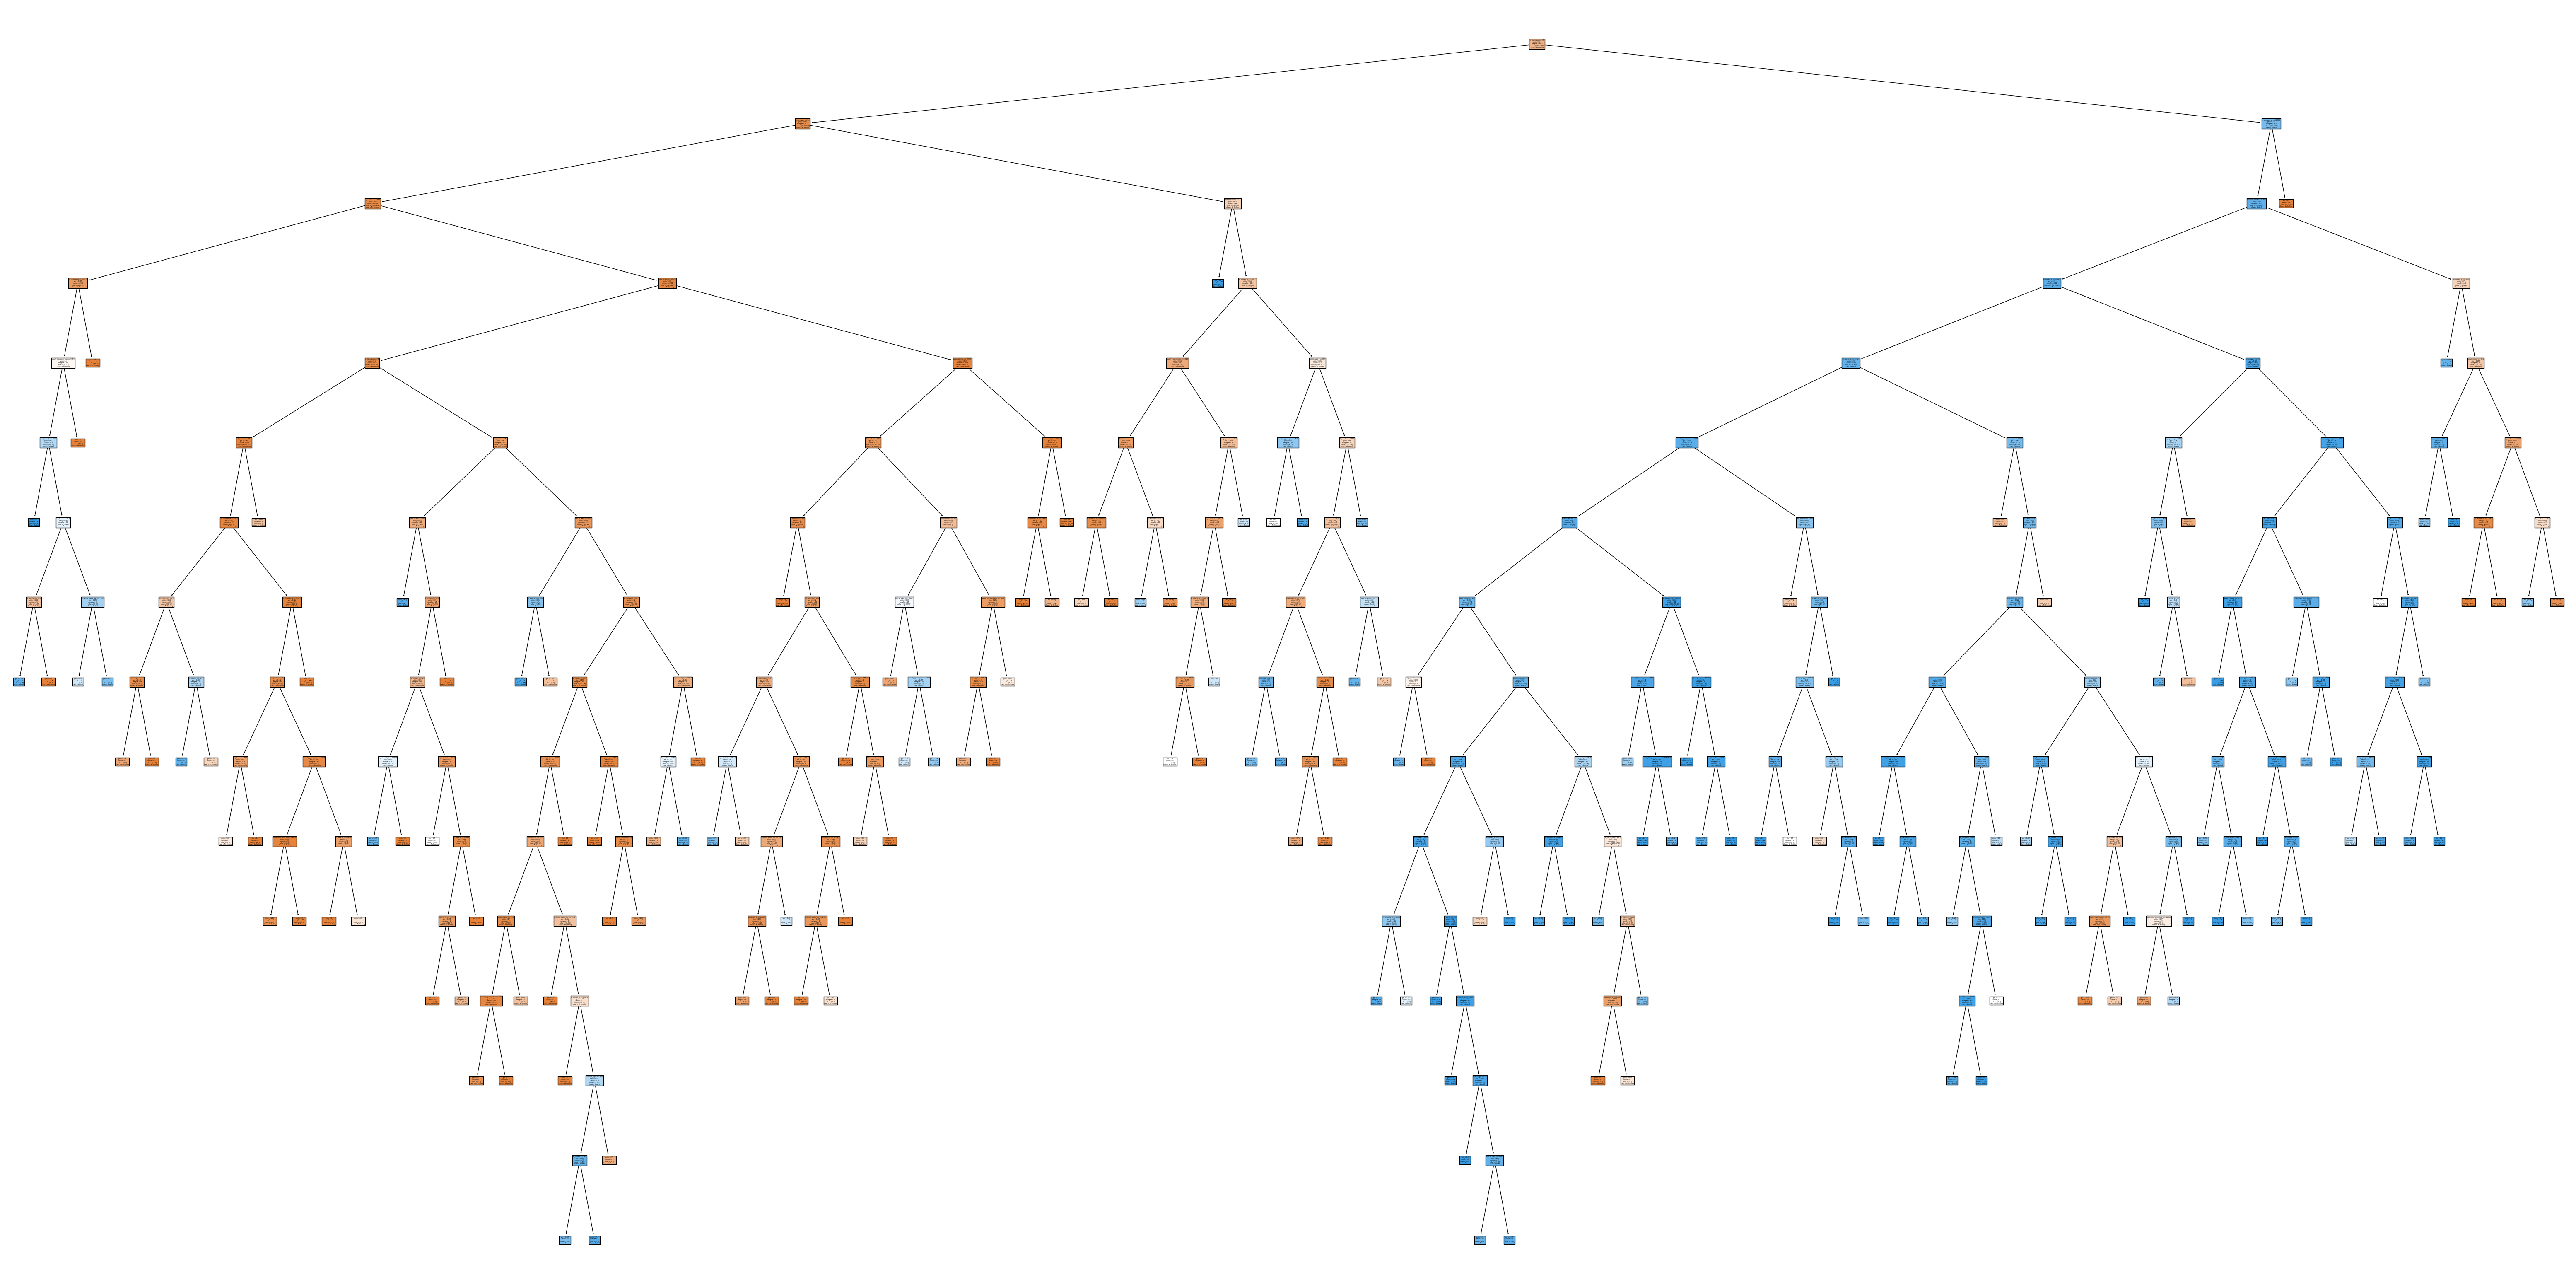

In [258]:
plt.figure(figsize=(80,40))
plot_tree(classifier_rf_filtered_20.estimators_[5], feature_names = X_filtered_20.columns,class_names=['No Booking', "Booked"],filled=True);

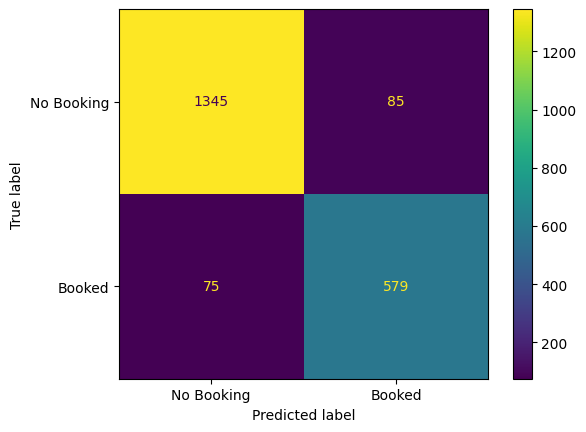

In [259]:
cm_filtered_20 = confusion_matrix(y_test_filtered_20, classifier_rf_filtered_20.predict(X_test_filtered_20))
ConfusionMatrixDisplay(cm_filtered_20, display_labels=['No Booking', 'Booked']).plot()

# Predict most likely to book based on country + time

In [266]:
booking_probabilities = classifier_rf_filtered_20.predict_proba(X_train_filtered_20)[:, 1]
booking_probabilities

array([0.15582236, 0.50540632, 0.95758322, ..., 0.002     , 0.01294129,
       0.88502876])

In [267]:
X_train_filtered_20['booking_proba'] = booking_probabilities

In [301]:
countries_df = pd.read_csv('../data/countries.csv')
country_name_mapping = dict(zip(countries_df['country'], countries_df['name']))
country_name_mapping

{'AD': 'Andorra',
 'AE': 'United Arab Emirates',
 'AF': 'Afghanistan',
 'AG': 'Antigua and Barbuda',
 'AI': 'Anguilla',
 'AL': 'Albania',
 'AM': 'Armenia',
 'AN': 'Netherlands Antilles',
 'AO': 'Angola',
 'AQ': 'Antarctica',
 'AR': 'Argentina',
 'AS': 'American Samoa',
 'AT': 'Austria',
 'AU': 'Australia',
 'AW': 'Aruba',
 'AZ': 'Azerbaijan',
 'BA': 'Bosnia and Herzegovina',
 'BB': 'Barbados',
 'BD': 'Bangladesh',
 'BE': 'Belgium',
 'BF': 'Burkina Faso',
 'BG': 'Bulgaria',
 'BH': 'Bahrain',
 'BI': 'Burundi',
 'BJ': 'Benin',
 'BM': 'Bermuda',
 'BN': 'Brunei',
 'BO': 'Bolivia',
 'BR': 'Brazil',
 'BS': 'Bahamas',
 'BT': 'Bhutan',
 'BV': 'Bouvet Island',
 'BW': 'Botswana',
 'BY': 'Belarus',
 'BZ': 'Belize',
 'CA': 'Canada',
 'CC': 'Cocos [Keeling] Islands',
 'CD': 'Congo [DRC]',
 'CF': 'Central African Republic',
 'CG': 'Congo [Republic]',
 'CH': 'Switzerland',
 'CI': "C�te d'Ivoire",
 'CK': 'Cook Islands',
 'CL': 'Chile',
 'CM': 'Cameroon',
 'CN': 'China',
 'CO': 'Colombia',
 'CR': 'Costa

In [304]:
country_name_mapping['EU'] = 'Europe'

In [300]:
country_le_mapping = {}
intermed_mapping = le.inverse_transform(X_train_filtered_20['origin_country'])
for idx, country_code in enumerate(X_train_filtered_20['origin_country']):
    country_le_mapping[country_code] = intermed_mapping[idx]
country_le_mapping

{25: 'GB',
 66: 'US',
 31: 'IE',
 24: 'FR',
 9: 'BR',
 36: 'IT',
 14: 'CR',
 48: 'NL',
 5: 'BE',
 63: 'TR',
 52: 'PT',
 3: 'AU',
 10: 'CA',
 20: 'ES',
 59: 'SG',
 54: 'RO',
 17: 'DE',
 56: 'RU',
 34: 'IN',
 32: 'IL',
 51: 'PL',
 11: 'CH',
 18: 'DK',
 0: 'AE',
 28: 'HR',
 1: 'AR',
 55: 'RS',
 29: 'HU',
 2: 'AT',
 12: 'CN',
 7: 'BG',
 49: 'NO',
 23: 'FI',
 64: 'TW',
 27: 'HK',
 58: 'SE',
 53: 'RE',
 39: 'KR',
 68: 'ZA',
 46: 'MY',
 37: 'JO',
 26: 'GR',
 16: 'CZ',
 65: 'UA',
 57: 'SA',
 61: 'SK',
 35: 'IS',
 50: 'NZ',
 40: 'KY',
 62: 'SM',
 41: 'LB',
 43: 'LU',
 60: 'SI',
 45: 'MX',
 47: 'NG',
 19: 'EC',
 38: 'JP',
 44: 'MT',
 42: 'LS',
 13: 'CO',
 33: 'IM',
 15: 'CY',
 22: 'EU',
 6: 'BF'}

In [308]:
countries = X_train_filtered_20['origin_country'].unique()
features_of_interest = X_train_filtered_20.columns[X_train_filtered_20.columns != 'origin_country'].tolist()

best_feature_vals_by_country = {}

for country in countries:
    data_country = X_train_filtered_20[X_train_filtered_20['origin_country'] == country]
    best_feature_vals = {}

    for feature in features_of_interest:
        mean_booking_prob_by_feature = data_country.groupby(feature)['booking_proba'].mean()
        best_feature_vals[feature] = mean_booking_prob_by_feature.idxmax() if (not mean_booking_prob_by_feature.empty and mean_booking_prob_by_feature.any()) else 'N/A'
    best_feature_vals_by_country[country] = best_feature_vals

for country_code, feature_values in best_feature_vals_by_country.items():
    print("Best Feature Values for {}:".format(country_name_mapping[country_le_mapping[country_code]]))
    for feature, value in feature_values.items():
        print("{}: {}".format(feature, value))

Best Feature Values for United Kingdom:
n_messages: 28
ts_accepted_at: 2310
time_to_reply: 86
search_n_nights: 6.0
ts_reply_at: 4630
n_searches: 6.7500
ds_checkout: 65
ds_checkin: 71
ts_contact_at: 5151
search_filter_price_max: 147.0
search_n_guests_max: 2.8750
search_n_guests_min: 2.6250
Entire home/apt: 8
n_guests: 13
Private room: 5
City Centre: 0
search_filter_price_min: 88.0
Shared room: 3
Temple Bar: 0
booking_proba: 0.984328373015873
Best Feature Values for United States:
n_messages: 33
ts_accepted_at: 2623
time_to_reply: 966
search_n_nights: 4.714285714285714
ts_reply_at: 5191
n_searches: 7.1429
ds_checkout: 84
ds_checkin: 68
ts_contact_at: 5677
search_filter_price_max: 270.0
search_n_guests_max: 3.3333
search_n_guests_min: 1.8571
Entire home/apt: 9
n_guests: 5
Private room: 6
City Centre: 3
search_filter_price_min: 16.0
Shared room: 2
Temple Bar: 3
booking_proba: 0.9840216797091798
Best Feature Values for Ireland:
n_messages: 26
ts_accepted_at: 1484
time_to_reply: 1
search_n_n

# With Additional Data

Based on the filtered_20 X, if there is a holiday w/in 7 days

In [310]:
holidays_df = pd.read_csv('../data/holidays.csv', parse_dates=['Date'])
holidays_df.head()

Country Country Code       Day       Date            Holiday Name  \
0  afghanistan           AF   Tuesday 2022-02-15          Liberation Day   
1  afghanistan           AF    Monday 2022-03-21                 Nowrooz   
2  afghanistan           AF   Tuesday 2022-03-22         Nowrooz Holiday   
3  afghanistan           AF    Sunday 2022-04-03                 Ramadan   
4  afghanistan           AF  Thursday 2022-04-28  Mujahideen Victory Day   

               Type                   Comments  
0  National Holiday                        NaN  
1  National Holiday            Afghan New Year  
2  National Holiday                        NaN  
3  National Holiday  Expected Start of Ramadan  
4  National Holiday                        NaN

In [311]:
holidays_df['Date'] = holidays_df['Date'].dt.date

In [312]:
X_filtered_20['Near_Holiday'] = 0

/var/folders/bm/2p55x4d9111982mgcnj9dcm80000gn/T/ipykernel_75731/2022564081.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_filtered_20['Near_Holiday'] = 0


In [314]:
X_filtered_20.head()

n_messages  ts_accepted_at  time_to_reply  search_n_nights  ts_reply_at  \
0          13             604              0              2.0         1239   
1          10            3081           2147              3.0         6000   
2           3            3295          11051              2.0         3367   
3           2            3295              0              2.0         6410   
4          14            1676            120              2.0         3371   

  n_searches  ds_checkout  ds_checkin  ts_contact_at  search_filter_price_max  \
0     6.0000           13          12           1497                    130.0   
1    13.0000           59          57           6486                    336.0   
2    32.5000           17          16           3708                    736.0   
3    32.5000           17          16           3773                    736.0   
4    32.5000           17          16           3771                    736.0   

   ...  search_n_guests_max search_n_guests_min Entire home/apt  n_guests  \
0  ...               2.0000              2.0000               1         2   
1  ...               1.0000              1.0000               1         1   
2  ...               2.0000              2.0000               3         2   
3  ...               2.0000              2.0000               3         2   
4  ...               2.0000              2.0000               3         2   

   Private room  City Centre  search_filter_price_min  Shared room  \
0             0            0                      0.0            0   
1             2            0                      0.0            0   
2             2            0                      0.0            0   
3             2            0                      0.0            0   
4             2            0                      0.0            0   

   Temple Bar  Near_Holiday  
0           0             0  
1           0             0  
2           0             0  
3           0             0  
4           0             0  

[5 rows x 21 columns]